In [1]:
import numpy as np

%matplotlib inline

bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

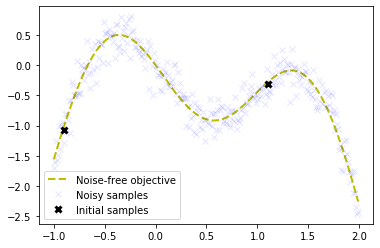

In [2]:
import matplotlib.pyplot as plt

# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X
Y = f(X, 0)

# Plot optimization objective with noise level
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend()

In [3]:
from scipy.stats import norm


def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    '''
    Computes the EI at points X based on existing samples X_sample
    and Y_sample using a Gaussian process surrogate model.
    
    Args:
        X: Points at which EI shall be computed (m x d).
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.
        xi: Exploitation-exploration trade-off parameter.
    
    Returns:
        Expected improvements at points X.
    '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = np.squeeze(sigma.reshape(-1, 1))

    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [1]
    mu_sample_opt = np.max(mu_sample)
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [4]:
from scipy.optimize import minimize


def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    '''
    Proposes the next sampling point by optimizing the acquisition function.
    
    Args:
        acquisition: Acquisition function.
        X_sample: Sample locations (n x d).
        Y_sample: Sample values (n x 1).
        gpr: A GaussianProcessRegressor fitted to samples.

    Returns:
        Location of the acquisition function maximum.
    '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)

    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:
            min_val = res.fun
            min_x = res.x

    return min_x.reshape(-1, 1)

In [5]:
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(),
                     mu.ravel() + 1.96 * std,
                     mu.ravel() - 1.96 * std,
                     alpha=0.1)
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate model')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

In [6]:
def plot_approximation2(s, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gprpredict(X, s, return_std=True)
    plt.fill_between(X.ravel(),
                     mu.ravel() + 1.96 * std,
                     mu.ravel() - 1.96 * std,
                     alpha=0.1)
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate model')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

In [7]:
def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()

In [8]:
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)

    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)

    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

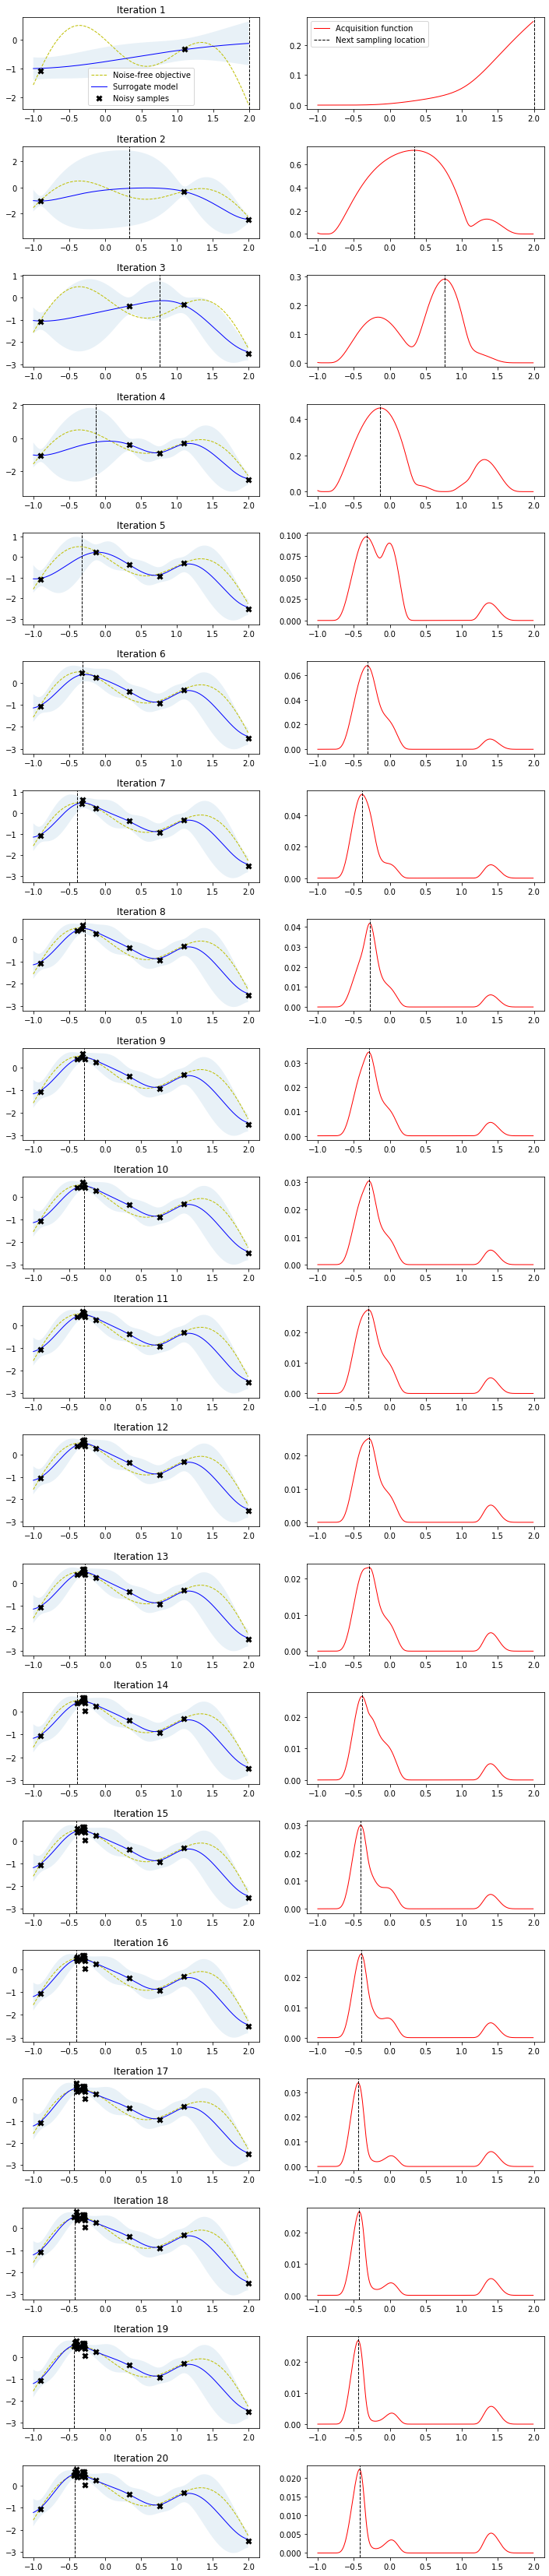

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)

    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)

    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample,
                       X_next, show_legend=i == 0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(
        X, X_sample, Y_sample, gpr), X_next, show_legend=i == 0)

    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))

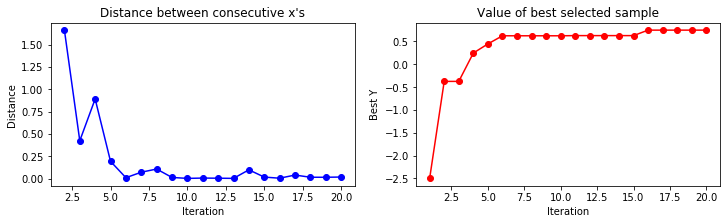

In [10]:
plot_convergence(X_sample, Y_sample)

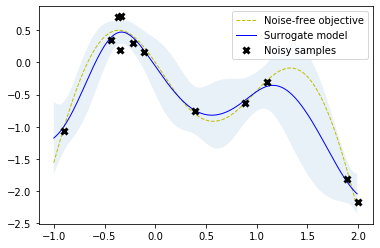

In [11]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

r = gp_minimize(lambda x: -f(np.array(x))[0],
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.01,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(),  # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)


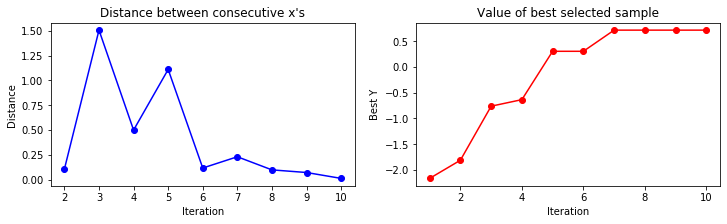

In [12]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

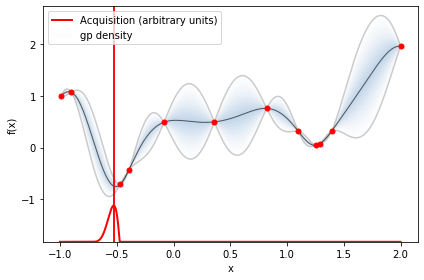

In [13]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f,
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type='EI',
                                 acquisition_jitter=0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var=noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

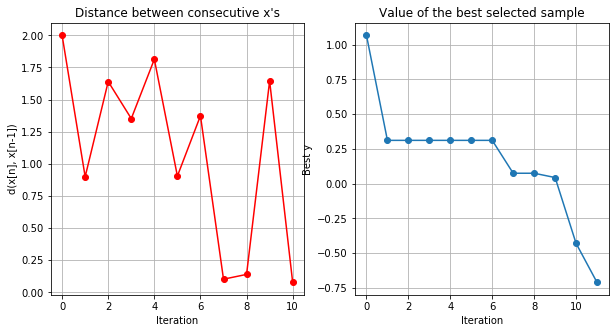

In [14]:
optimizer.plot_convergence()

In [15]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()


In [16]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1, 50),
              "n_estimators": range(1, 300),
              "min_child_weight": range(1, 10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist,
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y)

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_ca...
                                          reg_alpha=None, reg_lambda=None, ...),
                   n_iter=25,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x167c19420>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1766e2650>,
                                        'max_depth': range(1, 50),
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': range(1, 300)},
                   scoring='neg_mean_squared_error')

In [17]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
       {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
       {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
       {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
       {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective


def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     gamma=int(parameters[1]),
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     min_child_weight=parameters[4]),
        X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score


optimizer = BayesianOptimization(f=cv_score,
                                 domain=bds,
                                 model_type='GP',               # Gaussian Process
                                 acquisition_type='EI',         # Expected Improvement
                                 acquisition_jitter=0.05,
                                 exact_feval=True,
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

Baseline neg. MSE = -4216.24
Random search neg. MSE = -3569.69
Bayesian optimization neg. MSE = -3226.75


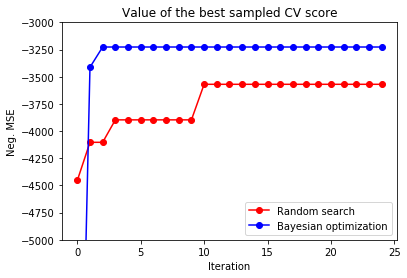

In [18]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score')
plt.legend()